# Data Generation, Visualization and Fitting Script

In [11]:
#import packages 
import pandas as pd
import numpy as np
from lmfit import minimize, Parameters, Model, Parameter
from scipy.optimize import fsolve 
from helper_functions import *
from matplotlib import pyplot as plt
import random
from numpy.random import normal 
import sympy as sy
random.seed(42)
from sympy.utilities.lambdify import lambdify

## Define Functions for Numerical Calculations

In [12]:
def calc_theta(X, K1, K2, w, Ct0, S):
    def mz(x):
        """
        if negative makes zero
        """
        x[x<=0] = 0
        return x 
    
    
    D, E = X
    
    M = 4*Ct0 + 4*D*Ct0*K1 - E**2*K1*K2*w + E**2*K1*K2*w**2 + D*E*K1*K2 - 4*E*Ct0*K1*w - D*E*K1*K2*w
    N = E**2*K1*K2*w - E**2*K1*K2*w**2 - D*E*K1*K2 - 2*E*Ct0*K1*w + D*E*K1*K2*w - 4*D*E*Ct0*K1**2*w
    top = np.sqrt(mz(-E*K1*K2*(D-E*w)*(w-1)*M))+2*D**2*Ct0*K1**2 + 2*D*Ct0*K1 + 2*E**2*Ct0*K1**2*w**2 + N
    #    -------------------------------------------------------------------------------------------------
    bot = 2*Ct0*D**2*K1**2 - 4*Ct0*D*E*K1**2*w + 4*Ct0*D*K1 + 2*Ct0*E**2*K1**2*w**2 - 4*Ct0*E*K1*w + 2*Ct0
    
    theta = S*top/bot

    theta[E<=0] = S*K1*D[E<=0]/(1+K1*D[E<=0])  # case of no salt, Ian model
    
    theta[D<=0] = 0  # case of no dopant, zero
    
    more_water_than_dopant = D-w*E<0
    theta[more_water_than_dopant] = 0
    theta[theta<0] = 0 

    return theta


In [13]:
def get_params(result):
    """
    Get the fitting params in a list from a lmfit result object
    """
    param_vals = [] #this generates data for all points in the curve 
    for key,val in result.params.items():
        param_vals.append(val.value)
    
    return param_vals

In [14]:
def calc_mse(y1_arr, y2_arr):
    total = 0
    for y1, y2 in zip(y1_arr, y2_arr):
        total += (y1 - y2)**2
    mse = total/len(y1_arr)
    return mse

## Generate Simulated Data Using Specified Parameters

#### Define Parameters

In [15]:
KI = 0.971
KII = 0.00079
Ct0 = 0.096
w = 0.0038
S = 0.79

#### Generate Simulated Data 

In [16]:
#Create simulated data 
#get range of concentrations 
C_FeCl3_arr = np.linspace(0.1,5,10)
C_LiTFSI_arr = [0, 50, 100]


# match together concentrations 
X_FeCl3 = []
X_LiTFSI = []
for C_FeCl3 in C_FeCl3_arr:
    for C_LiTFSI in C_LiTFSI_arr:
        X_FeCl3.append(C_FeCl3)
        X_LiTFSI.append(C_LiTFSI)
        
X = (np.array(X_FeCl3), np.array(X_LiTFSI))
theta_real = calc_theta(X, KI, KII, w, Ct0, S)  
theta_noise = normal(0, .01, size=len(theta_real))  # add noise to data 
theta_sim = theta_real + theta_noise 

data_dict = {'theta': theta_sim, 'FeCl3 (mM)': X_FeCl3, 'LiTFSI (mM)': X_LiTFSI }
data = pd.DataFrame(data_dict)

pd.set_option("display.max_rows", None, "display.max_columns", None)
data

,theta,FeCl3 (mM),LiTFSI (mM)
0,0.077682,0.100000,0
1,0.005499,0.100000,50
2,-0.013407,0.100000,100
3,0.288456,0.644444,0
4,0.415256,0.644444,50
5,0.351982,0.644444,100
6,0.417004,1.188889,0
7,0.536677,1.188889,50
8,0.529300,1.188889,100
9,0.493041,1.733333,0


#### Visualize Simulated Data 

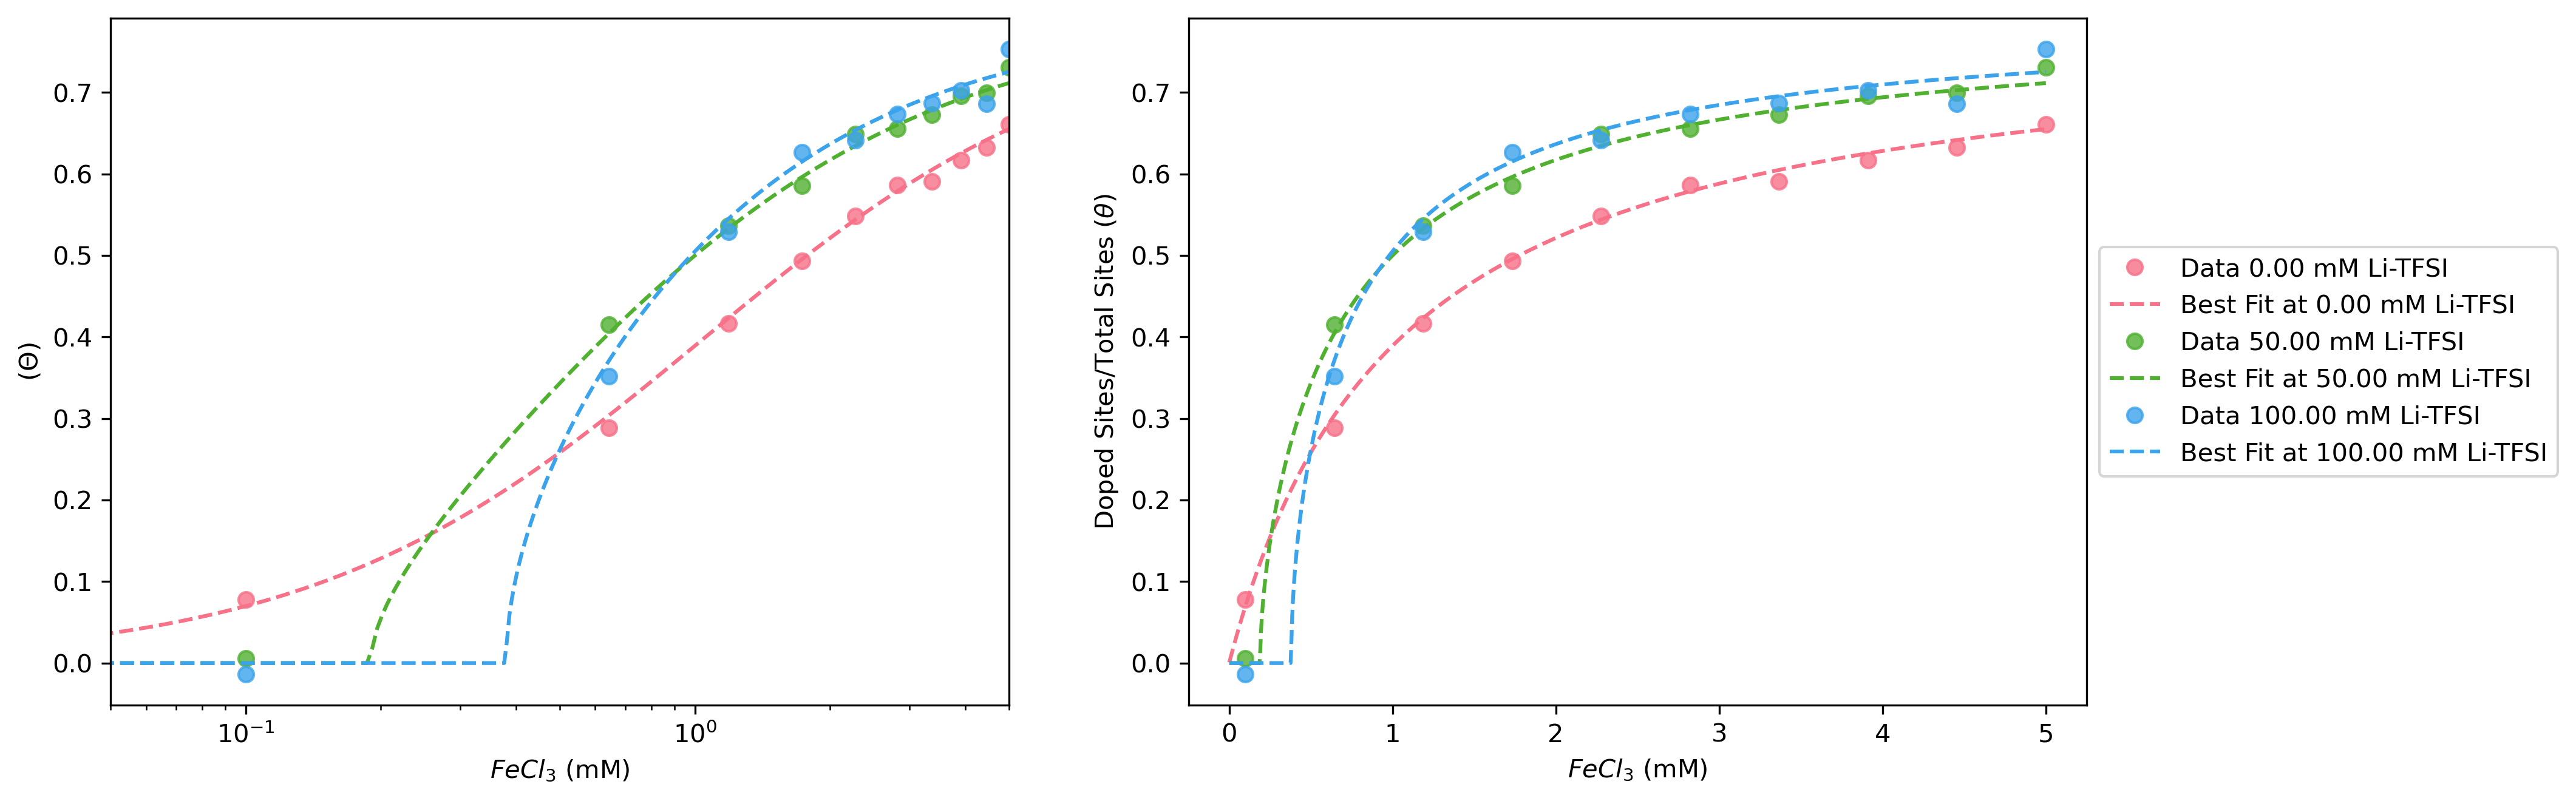

In [17]:
D = data.to_numpy()
X = (D[:,1], D[:,2])
y = D[:,0]
param_vals = [KI, KII, w, Ct0, S] #this generates data for all points in the curve 

#plotting data we need to use a different function that isn't log loss 
#plot_data_and_fit_nonclosed(D[:,1], D[:,2], y, calc_theta, param_vals, title='')

plot_halotherms(X, y, calc_theta, param_vals, title='')

##  Fit Data

#### Define model parameters

In [18]:
params = lmfit.Parameters()
params.add('K1',10,min=0,max=1e10,vary=True)
params.add('K2',1, min=1e-8,max=1e5,vary=True)
params.add('w',0.004,min=0,max=1,vary=True) 
params.add('Ct0',0.0965,min=0,max=1,vary=False) 
params.add('S',0.9,min=0,max=1,vary=True) 

isotherm_model = Model(calc_theta)

In [19]:
D = data.to_numpy()
X = (D[:,1], D[:,2])
y = D[:,0]
fit_result = isotherm_model.fit(y, params, X=X, method='leastsq')
fit_params = get_params(fit_result)
y_pred = calc_theta(X, *fit_params)
mse = calc_mse(y, y_pred)
print(f"MSE {mse}")
fit_result.params.pretty_print()

MSE 0.000141337175419387
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Ct0    0.0965        0        1        0    False     None     None
K1     0.9566        0    1e+10  0.04193     True     None     None
K2   0.0008768    1e-08    1e+05 0.0001294     True     None     None
S      0.7881        0        1 0.008596     True     None     None
w    0.004187        0        1 0.0003094     True     None     None


### Plotting Fitting results

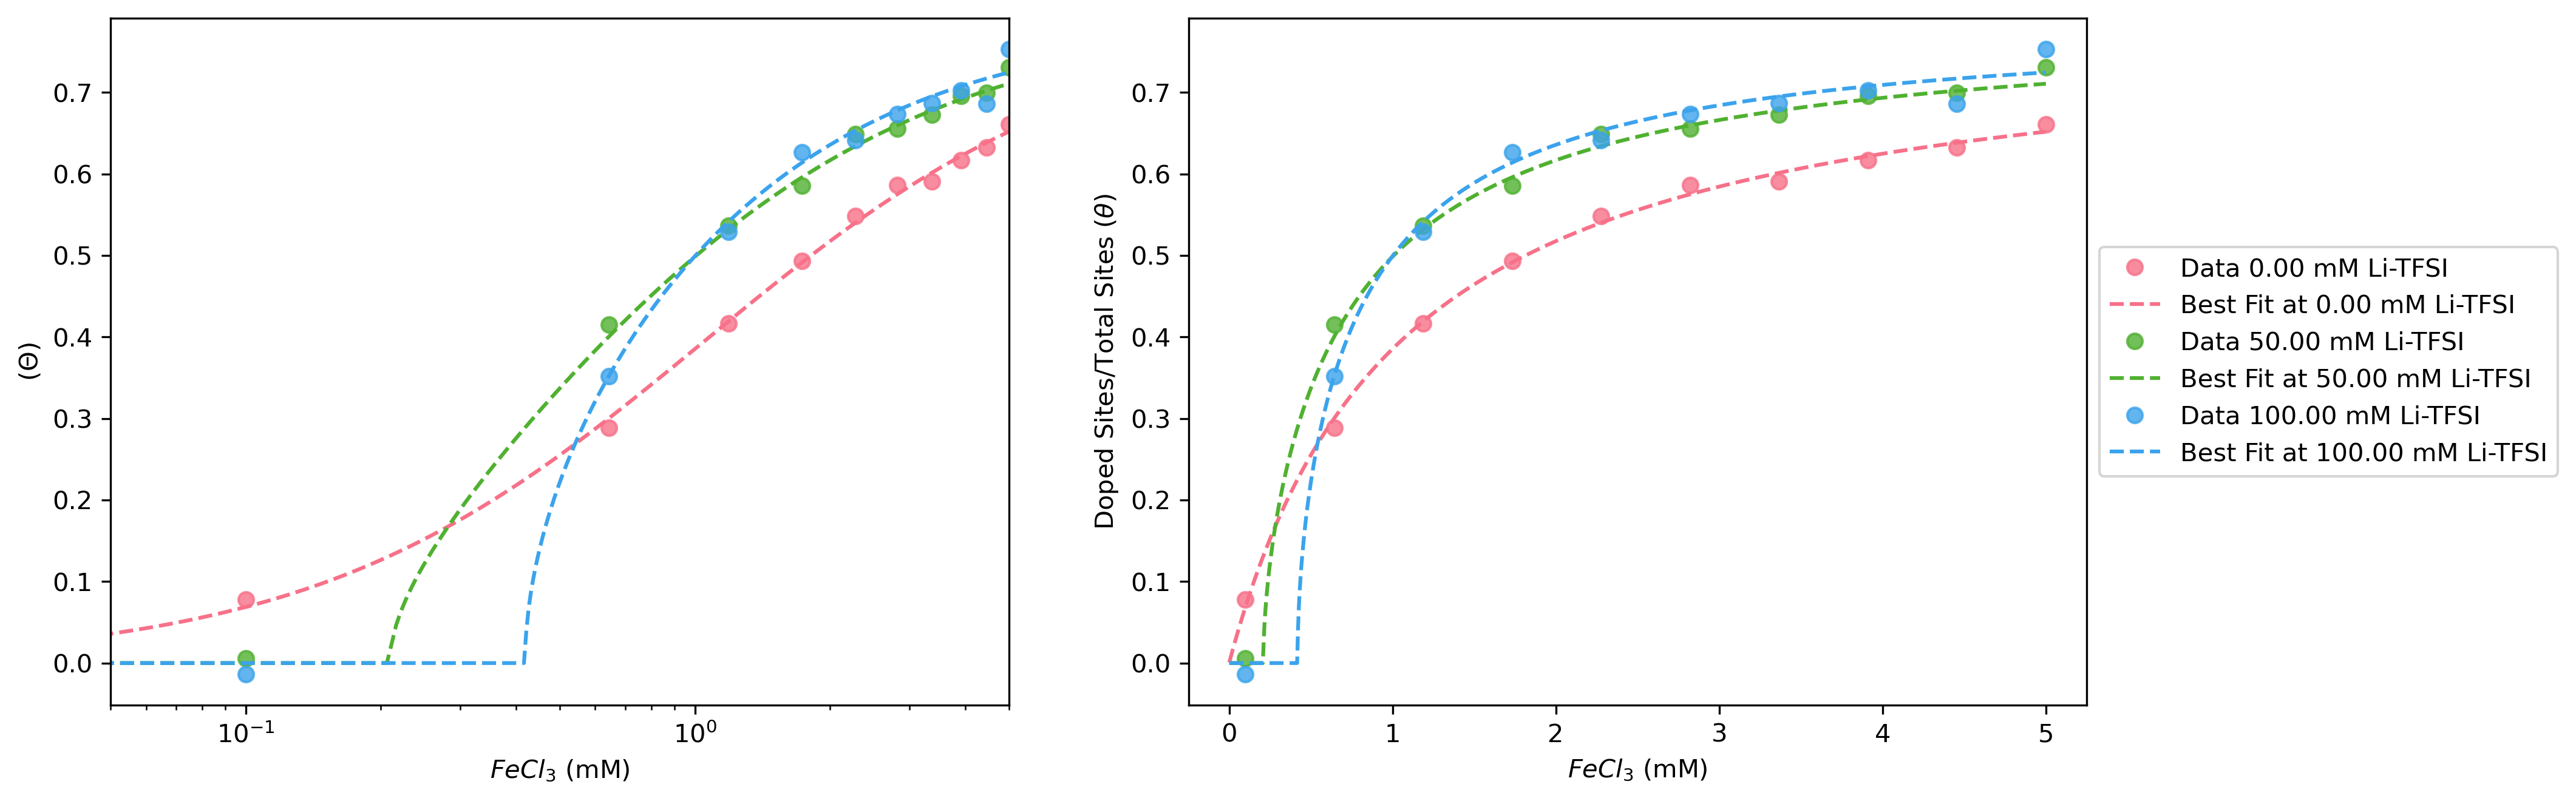

In [20]:
param_vals = [] #this generates data for all points in the curve 
for key,val in fit_result.params.items():
    param_vals.append(val.value)
#plotting data we need to use a different function that isn't log loss 
#plot_data_and_fit_nonclosed(D[:,1], D[:,2], y, calc_theta, param_vals, title='')

plot_halotherms(X, y, calc_theta, param_vals, title='')